In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from collections import defaultdict

In [2]:
# importing data
all_cell_markers_df = pd.read_csv('../data/all_cell_markers.txt', sep = r'\t')
all_human_markers_df = pd.read_csv('../data/Human_cell_markers.txt', sep = r'\t')
all_mouse_markers_df = pd.read_csv('../data/Mouse_cell_markers.txt', sep = r'\t')
all_singleCell_markers_df = pd.read_csv('../data/Single_cell_markers.txt', sep = r'\t')

/opt/anaconda3/envs/scripps_microbiome/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


# Data Schema
- **speciesType**: the species from which the data originates
    - there are only two data type, either `Human` or `Mouse`
- **tissueType**: the type of tissues from which data originates
    - in total 181 different kinds of cells
    - a lot of them are undefined
- **UberonOntologyID**: The universal unique identifier of the anatomy structure found in animals 
    - needs to confirm with the team
    - contain missing value
- **cancerType**: the association of the cell marker with the cancer name
    - no cancer cell are named as `Normal`
- **cellName**: the English name of the cell that marker belong to
- **CellOntologyID**: The universal unique identifier of the cell that marker belong to
    - contain missing value
- **cellMarker**: a marker molecule of the cell
    - in string list, can be convert to list
- **geneSymbol**: gene expression of the cell marker
- **geneID**: The universal unique identifier of the gene
    - contain missing value
- **proteinName**: name of the protein
    - contain missing value
- **proteinID**: The universal unique identifier of the protein
- **markerResource**: the type of resouce or methologoy used to identify the marker
    - there are only four data type, either `Experiment` or `Single-cell sequencing` or `Company` or `Review`
- **PMID**: The PudMed ID for the publication or study where the marker data was reported
    - abnormal value contain `company`
- **Company**: the company associated with the resouces

# Missingness of the vlaues

In [3]:
all_cell_markers_df.isna().mean()

speciesType         0.000000
tissueType          0.000000
UberonOntologyID    0.180936
cancerType          0.000000
cellType            0.000000
cellName            0.000000
CellOntologyID      0.210526
cellMarker          0.000000
geneSymbol          0.012127
geneID              0.012127
proteinName         0.013582
proteinID           0.013582
markerResource      0.000000
PMID                0.000000
Company             0.913898
dtype: float64

# Exploration on all_cell_markers
Notes: all codes a modulerized, which means you can directly jump to a specific section without running previous sections

EDA outlines:
- Confirming hypothesis: `all_cell_markers` contain all the data from `all_human_markers`, `all_mouse_markers`
- Confirming hypothesis: None of the data from `all_singleCell_markers` exist in `all_cell_markers`
- Revealing trend: assoication between missing `UberonOntologyID` and `tissueType`
- Revealing trend: assoication between missing `CellOntologyID` and `cellName`
- Confirming hypothesis: if `geneSymbol` is missing, then `geneID` is not missing
- Confirming hypothesis: if `proteinName` is missing, then `proteinID` is not missing
- Revealing trend: find the the pattern of the mistached elements of all the list-like str columns
- Confirming hypothesis: if markerResource is `company`, then `PMID` is company and `Company` is not missing
- explore categorical data

## Confirm Hypothesis
`all_cell_markers` contain all the data from `all_human_markers`, `all_mouse_markers`

In [4]:
all_cell_marker_tuple = all_cell_markers_df.apply(tuple, axis=1)
all_human_marker_tuple = all_human_markers_df.apply(tuple, axis=1)
all_mouse_markers_tuple = all_mouse_markers_df.apply(tuple, axis=1)

# check if all value in human_marker exist in cell_marker
if all(all_human_marker_tuple.isin(all_cell_marker_tuple)):
    print("all value in all_human_marker dataset exist in all_cell_marker dataset")
else:
    mismatch_value = sum(all_human_marker_tuple.isin(all_cell_marker_tuple) == False)
    print(f"there are {mismatch_value} from all_human_marker that does not exist in all_cell_marker dataset")

# check if all value in mouse_marker exist in cell_marker
if all(all_mouse_markers_tuple.isin(all_cell_marker_tuple)):
    print("all value in all_mouse_markers dataset exist in all_cell_marker dataset")
else:
    mismatch_value = sum(all_mouse_markers_tuple.isin(all_cell_marker_tuple) == False)
    print(f"there are {mismatch_value} from all_mouse_markers that does not exist in all_cell_marker dataset")



all value in all_human_marker dataset exist in all_cell_marker dataset
all value in all_mouse_markers dataset exist in all_cell_marker dataset


## Confirm Hypothesis
None of the data from `all_singleCell_markers` exist in `all_cell_markers`

In [5]:
all_cell_marker_tuple = all_cell_markers_df.apply(tuple, axis=1)
all_singleCell_markers_tuple = all_singleCell_markers_df.apply(tuple, axis=1)

# check if all value in singleCell_marker exist in cell_marker
if all(all_singleCell_markers_tuple.isin(all_cell_marker_tuple)):
    print("all value in all_singleCell_markers dataset exist in all_cell_marker dataset")
else:
    mismatch_value = sum(all_singleCell_markers_tuple.isin(all_cell_marker_tuple) == False)
    print(f'there are in total {mismatch_value} records in all_singleCell_markers')
    print(f"there are {mismatch_value} from all_singleCell_markers that does not exist in all_cell_marker dataset")

there are in total 535 records in all_singleCell_markers
there are 535 from all_singleCell_markers that does not exist in all_cell_marker dataset


## Revealing trend
assoication between missing `UberonOntologyID` and `tissueType`

most of the tissue with missing ID is undefined tissue

In [6]:
cell_markers_df = pd.concat([all_cell_markers_df, all_singleCell_markers_df], axis = 0, ignore_index=True)
cell_markers_df[['UberonOntologyID', 'tissueType']][cell_markers_df['UberonOntologyID'].isna()].tissueType.value_counts()

Undefined                      701
Fetal liver                     29
Fetal gonad                     26
Embryonic prefrontal cortex     12
Bladder                          5
Sinonasal mucosa                 2
Fetal brain                      1
Osteoarthritic cartilage         1
Name: tissueType, dtype: int64

# Revealing trend
assoication between missing `CellOntologyID` and `cellName`

In [7]:
cell_markers_df = pd.concat([all_cell_markers_df, all_singleCell_markers_df], axis = 0, ignore_index=True)
cell_markers_df[['CellOntologyID', 'cellName']][cell_markers_df['CellOntologyID'].isna()].cellName.value_counts()

Cancer stem cell                    596
Progenitor cell                      53
Cancer stem-like cell                 9
Neural progenitor cell                8
Cardiac progenitor cell               8
                                   ... 
Foxp3+IL-17+ T cell                   1
Definitive zone cell                  1
Bone marrow stem cell                 1
PDX1+ pancreatic progenitor cell      1
Adipogenic progenitor cell            1
Name: cellName, Length: 142, dtype: int64

# Confirming hypothesis
if `geneSymbol` is missing, then `geneID` is not missing

In [8]:
cell_markers_df = pd.concat([all_cell_markers_df, all_singleCell_markers_df], axis = 0, ignore_index=True)
check_same = cell_markers_df[['geneSymbol', 'geneID']].apply(
    lambda row: all(row.isna()) or all(~row.isna()), axis = 1 
)
if all(check_same):
    print('if there is a missing proteinSymbol, then there must be missing proteinID')
else:
    print('if there is a missing symbol then there might exist a ID')

if there is a missing proteinSymbol, then there must be missing proteinID


# Confirming hypothesis
if `proteinName` is missing, then `proteinID` is not missing

In [9]:
cell_markers_df = pd.concat([all_cell_markers_df, all_singleCell_markers_df], axis = 0, ignore_index=True)
check_same = cell_markers_df[['proteinName', 'proteinID']].apply(
    lambda row: all(row.isna()) or all(~row.isna()), axis = 1 
)
if all(check_same):
    print('if there is a missing proteinSymbol, then there must be missing proteinID')
else:
    print('if there is a missing symbol then there might exist a ID')

if there is a missing proteinSymbol, then there must be missing proteinID


## Revealing Trend
find the the pattern of the mistached elements of all the list-like str columns

In [10]:
cell_markers_df = pd.concat([all_cell_markers_df, all_singleCell_markers_df], axis = 0, ignore_index=True)
def str_to_list(listLikeStr):
    if not isinstance(listLikeStr, str): return ['NA']
    cleaned_listLikeStr = listLikeStr.replace("'", "")

    split_element = cleaned_listLikeStr.split(',')

    is_nested = False
    result = []
    nested_list = []

    # try to improve
    for element in split_element:
        if is_nested:
            if "]" in element:
                is_nested = False
                element = element.replace(']', "").strip()
                # lowercase
                # if element.casefold() == 'na':
                #     continue
                nested_list.append(element)
                result.append(nested_list)
                nested_list = []
            else:
                element = element.strip()
                # if element.casefold() == 'na':
                #     continue
                if element:
                    nested_list.append(element.strip())
        else:
            if "[" in element:
                is_nested = True
                element = element.replace('[', "").strip()
                # if element.casefold() == 'na':
                #     continue
                nested_list.append(element)
            else:
                element = element.strip()
                # if element.casefold() == 'na':
                #     continue
                if element:
                    result.append(element)

    return result
        

to_convert_col  = ['cellMarker', 'geneSymbol', 'geneID', 'proteinName', 'proteinID']


for col in to_convert_col:
    cell_markers_df[col] = cell_markers_df[col].apply(str_to_list)

len_count = cell_markers_df[to_convert_col].applymap(len)

if cell_markers_df[to_convert_col].applymap(lambda x: len(x) if isinstance(x, list) else np.NaN).dropna().shape[0] == 0:
    print("each existed cellMarkers have a gene name assoicated it")
else:
    print('some gene has mis-match sequence')
    mistamch_index = len_count[len_count.nunique(axis = 1) != 1].index
    print(f"for these following index: {mistamch_index}")

some gene has mis-match sequence
for these following index: Int64Index([3135, 3151, 3226, 3227, 3228, 3243, 3632, 3710, 3733, 3741, 3844,
            3908, 3973, 3977, 3983, 4005, 4099, 4167, 4245, 4268, 4276, 4379,
            4443, 4508, 4512, 4518, 4540, 4634],
           dtype='int64')


In [11]:
mistach_cell_markers = cell_markers_df.loc[mistamch_index]
mt_mr_dis = mistach_cell_markers.markerResource.value_counts(normalize=True)

In [12]:
mistach_cell_markers.shape[0] #/ cell_markers_df.shape[0] * 100

28

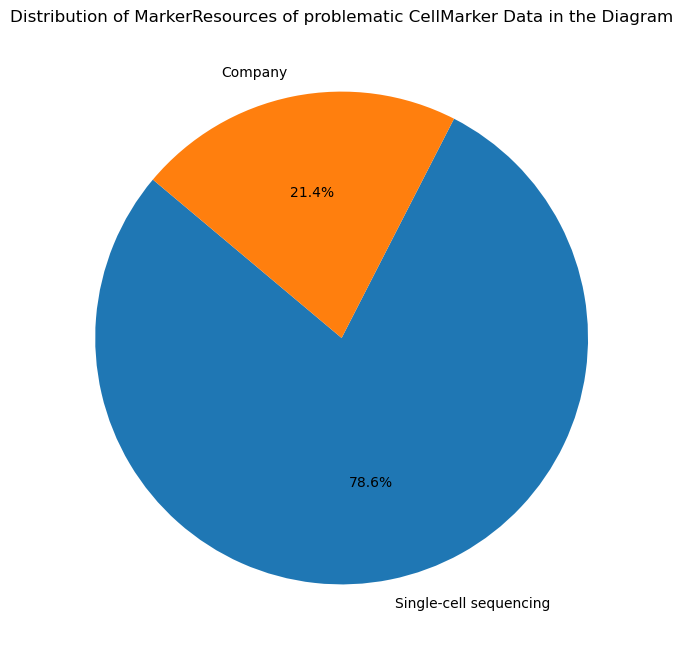

In [13]:
plt.figure(figsize=(8, 8))
plt.pie(mt_mr_dis, labels=mt_mr_dis.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of MarkerResources of problematic CellMarker Data in the Diagram')
plt.show()

In [14]:
# Examples of mismatch
cell_markers_df.loc[3973] # additional NA at the end
cell_markers_df.loc[3741] # total mismatch
cell_markers_df.loc[3710] # total mismatch
;

''

## Confirming hypothesis
if markerResource is `company`, then `PMID` is company and `Company` is not missing

In [15]:
cell_markers_df = pd.concat([all_cell_markers_df, all_singleCell_markers_df], axis = 0, ignore_index=True)

cell_marker_iscompany = cell_markers_df[['markerResource', 'PMID', 'Company']].assign(is_company = cell_markers_df['markerResource'] == 'Company')

# if is_company is false, then should PMID should not be company and Company is should be NaN
for row in cell_marker_iscompany.iterrows():
    row = row[1]
    if row[-1]:
        if row[1] == "Company" and pd.notna(row[2]):
            continue
        else:
            print(row)
    else:
        if row[1] != "Company" and pd.isna(row[2]):
            continue
        else:
            print(row)
print('all row match the expected format')

all row match the expected format


## Revealing Trend
check if there is categorical data in the datatest

In [16]:
cell_markers_df = pd.concat([all_cell_markers_df, all_singleCell_markers_df], axis = 0, ignore_index=True)

In [17]:
# find all possible values in each attribute
cell_markers_df.nunique()

speciesType            2
tissueType           181
UberonOntologyID     172
cancerType           133
cellType               2
cellName             681
CellOntologyID       281
cellMarker          2517
geneSymbol          2485
geneID              2487
proteinName         2350
proteinID           2481
markerResource         4
PMID                2462
Company                8
dtype: int64

In [18]:
# based on the unique values, speciesType, cellType, markerResource, Company

cadidate_speciesType = ['speciesType', 'cellType', 'markerResource', 'Company']

for col in cadidate_speciesType:
    print(f"unique value in {col} is {cell_markers_df[col].unique()}")

unique value in speciesType is ['Human' 'Mouse']
unique value in cellType is ['Normal cell' 'Cancer cell']
unique value in markerResource is ['Experiment' 'Company' 'Review' 'Single-cell sequencing']
unique value in Company is [nan 'miltenyibiotec' 'rndsystems' 'biolegend' 'bdbiosciences' 'abcam'
 'bio-rad-antibodies' 'ebioscience' 'labome']


In [19]:
# handle speciall case
# tiisueType: 15% is Undefined
cell_markers_df['tissueType'].value_counts(normalize=True)

Undefined         0.150494
Brain             0.072563
Bone marrow       0.065693
Lung              0.062473
Liver             0.054315
                    ...   
Gastric corpus    0.000215
Nerve             0.000215
Oviduct           0.000215
Nasal concha      0.000215
Umbilical vein    0.000215
Name: tissueType, Length: 181, dtype: float64

# Parsing procedure

Data Parsing Outlines
- concat `all_cell_markers` and `all_singleCell_markers`
- replace all the `undefined` tissue to NaN value
- convert all the strLikelist into list
- remove all rows with missing geneID

In [20]:
# importing dataframe
all_cell_markers_df = pd.read_csv('../data/all_cell_markers.txt', sep = r'\t')
all_human_markers_df = pd.read_csv('../data/Human_cell_markers.txt', sep = r'\t')
all_mouse_markers_df = pd.read_csv('../data/Mouse_cell_markers.txt', sep = r'\t')
all_singleCell_markers_df = pd.read_csv('../data/Single_cell_markers.txt', sep = r'\t')

In [21]:
def str_to_list(listLikeStr):
    if not isinstance(listLikeStr, str): return ['NA']
    cleaned_listLikeStr = listLikeStr.replace("'", "")

    split_element = cleaned_listLikeStr.split(',')

    is_nested = False
    result = []
    nested_list = []

    # try to improve
    for element in split_element:
        if is_nested:
            if "]" in element:
                is_nested = False
                element = element.replace(']', "").strip()
                # lowercase
                # if element.casefold() == 'na':
                #     continue
                nested_list.append(element)
                result.append(nested_list)
                nested_list = []
            else:
                element = element.strip()
                # if element.casefold() == 'na':
                #     continue
                if element:
                    nested_list.append(element.strip())
        else:
            if "[" in element:
                is_nested = True
                element = element.replace('[', "").strip()
                # if element.casefold() == 'na':
                #     continue
                nested_list.append(element)
            else:
                element = element.strip()
                # if element.casefold() == 'na':
                #     continue
                if element:
                    result.append(element)

    return result

In [22]:
# concatnating all_cell_markers and all_singleCell_markers
cell_markers_df = pd.concat([all_cell_markers_df, all_singleCell_markers_df], axis = 0, ignore_index=True)

# dropping column proteinName and proteinID
cell_markers_df.drop(columns=['proteinName', 'proteinID'], inplace=True)

# we don't consider record with missing geneID
cell_markers_df = cell_markers_df.dropna(subset=['geneID'])

# change all the Undefined value in tissueType column to NaN
cell_markers_df['tissueType'] = cell_markers_df['tissueType'].replace('Undefined', np.NaN)

# convert specific columns into list
to_convert_col  = ['cellMarker', 'geneSymbol', 'geneID']
for col in to_convert_col:
    cell_markers_df[col] = cell_markers_df[col].apply(str_to_list)



In [23]:
raise ValueError()

ValueError: 

## Play ground

In [ ]:
y = cell_markers_df[cell_markers_df[['cellMarker', 'geneSymbol', 'geneID']].applymap(len).nunique(axis=1) != 1]

In [401]:
y[['geneID', 'geneSymbol', 'cellMarker']].applymap(len)

,geneID,geneSymbol,cellMarker
3151,35,35,36
3226,21,21,20
3227,21,21,20
3228,21,21,20
3632,13,12,13
3844,454,465,454
3983,277,252,252
4005,98,97,98
4099,190,190,200
4167,13,12,13


In [ ]:
# due to out-dated data
# provide a more detailized example
# ignore the cellmarker column

# query mygene.info for their case
# hardcode the result
# use mygene.info to get the correct one
# do it separate from the parser

# sometimes there is an issue with the geneSymbol, maybe make another query in the future to confirm with the result


# hardcore the mismatch between genes


# road map
- redesign the schema
- hardcode missing-gene


In [398]:
y[['cellMarker', 'geneSymbol', 'geneID']].loc[3632].loc['cellMarker']#.applymap(len)#.shape[0]

['CD11b',
 'CD123',
 'CD19',
 'CD20',
 'CD3',
 'CD33',
 'CD34',
 'CD38',
 'CD4',
 'CD45',
 'CD45RA',
 'CD8',
 'CD90']

In [397]:
y[['cellMarker', 'geneSymbol', 'geneID']].loc[3632].loc['geneSymbol']#.applymap(len)#.shape[0]

['ITGAM',
 'IL3RA',
 'CD19',
 'MS4A1',
 ['CD3D', 'CD3E', 'CD3GCD33'],
 'CD34',
 'CD38',
 'CD4',
 'PTPRC',
 'NA',
 'CD8A',
 'THY1']

In [353]:
# ignore the mistmatch rows
cell_markers_df = cell_markers_df[cell_markers_df[['cellMarker', 'geneSymbol', 'geneID']].applymap(len).nunique(axis=1) == 1]

In [354]:
def unnest(ele_list: list):
    result = []
    for ele in ele_list:
        if isinstance(ele, list):
            result += ele
        else:
            result.append(ele)

    return result

In [355]:
# flattening the dataset
cell_markers_df['cellMarker'] = cell_markers_df['cellMarker'].apply(unnest)
cell_markers_df['geneSymbol'] = cell_markers_df['geneSymbol'].apply(unnest)
cell_markers_df['geneID'] = cell_markers_df['geneID'].apply(unnest)
cell_markers_df['comb'] = cell_markers_df[['cellMarker', 'geneSymbol', 'geneID']].apply(lambda row: [triplets for triplets in zip(*row)], axis=1)
cell_markers_df = cell_markers_df.drop(columns=['cellMarker', 'geneSymbol', 'geneID']).explode(column='comb')
cell_markers_df['cellMarker'] = cell_markers_df['comb'].apply(lambda x : x[0])
cell_markers_df['geneSymbol'] = cell_markers_df['comb'].apply(lambda x : x[1])
cell_markers_df['geneID'] = cell_markers_df['comb'].apply(lambda x : x[2])
cell_markers_df.drop(columns=['comb'], inplace=True)
cell_markers_df = cell_markers_df.applymap(lambda var: str(var) if not pd.isna(var) else np.nan)
cell_markers_df.drop_duplicates(inplace=True)


In [ ]:
x = cell_markers_df[cell_markers_df['geneID'] == '248']


In [ ]:
gene_cellMarker = dict()

In [ ]:
for row in cell_markers_df.iterrows():
    speciesType, tissueType, UberonOntologyID, cancerType, cellType, cellName, CellOntologyID, markerResource, PMID, Company, cellMarker, geneSymbol, geneID = row[1]

    if gene_cellMarker[]

In [174]:
cell_markers_df.columns

Index(['speciesType', 'tissueType', 'UberonOntologyID', 'cancerType',
       'cellType', 'cellName', 'CellOntologyID', 'markerResource', 'PMID',
       'Company', 'cellMarker', 'geneSymbol', 'geneID'],
      dtype='object')

In [89]:
for i in cell_markers_df['geneID'].values:
    print(i)
    
    
    
    #.value_counts()#.groupby('geneID')#['geneSymbol'].count()

248
6855
634
54514
1316
2255
214
5788
928
7070
79923
5460
3975
83881
947
4345
4322
4856
3491
3684
929
3689
['2212', '2213', '9103']
968
1003
5175
947
57142
960
4162
1280
1758
NA
56955
5251
50964
4684
860
4282
2778
3670
2752
3684
['2214', '2215']
930
914
['915', '916', '917']
4684
3824
3821
3684
['2214', '2215']
930
914
['915', '916', '917']
4684
3824
3821
648
960
79923
5460
2022
214
3688
960
3678
4907
7070
ALDH family
216
960
2022
929
5175
947
960
4907
7070
929
930
931
939
['915', '916', '917']
952
973
IgG family
3383
56241
6662
2022
NA
4684
2022
3688
960
4907
7216
930
939
952
5788
IgD family
7535
4162
7070
9314
79923
10763
5460
5159
6657
947
5156
4804
3673
3902
3655
771
100133941
2294
3880
5075
5764
2022
4162
947
5788
4907
7070
5460
NA
1301
7070
3683
3684
8778
55423
3689
1234
914
4063
940
['915', '916', '917']
3903
57823
['2212', '2213', '9103']
114836
920
6693
5788
NA
5788
962
921
3385
1043
963
923
923
969
924
11025
942
10225
1237
HLA-DR family
3563
1003
10544
7010
3643
7102
608
657


In [88]:
x = cell_markers_df[cell_markers_df[['cellMarker', 'geneSymbol', 'geneID']].applymap(len).nunique(axis=1) != 1]

In [23]:
x[['cellMarker', 'geneSymbol', 'geneID']].applymap(len)

,cellMarker,geneSymbol,geneID
3151,36,35,35
3226,20,21,21
3227,20,21,21
3228,20,21,21
3632,13,12,13
3844,454,465,454
3983,252,252,277
4005,98,97,98
4099,200,190,190
4167,13,12,13


In [19]:
def flatten_list(nested_list):
    return [item for sublist in nested_list for item in (sublist if isinstance(sublist, list) else [sublist]) if item != 'NA']
geneID_dict = defaultdict(dict)



for _, row in cell_markers_df[['cellMarker', 'geneSymbol', 'geneID', 'proteinName', 'proteinID']].iterrows():
    

    for cellMarker, geneSymbol, geneID, proteinName, proteinID in zip(*[flatten_list(ele) for ele in row]):
        
        cur_gene_dict = geneID_dict[geneID]
        
        # geneSymbol: unique to the geneID
        if 'geneSymbol' in cur_gene_dict:
            cur_gene_dict['geneSymbol'].add(geneSymbol)
        else:
            cur_gene_dict['geneSymbol'] = {geneSymbol}

        # assoicate protein
        if 'associate_protein' in cur_gene_dict:
            cur_gene_dict['associate_protein'].add((proteinID, proteinName))
        else:
            cur_gene_dict['associate_protein'] = {(proteinID, proteinName)}

        # associate cellMarker
        if 'associate_cellMarker' not in cur_gene_dict:
            cur_gene_dict['associate_cellMarker'] = dict()

        cur_gene_dict['associate_cellMarker'][cellMarker] = {'info1': 'content1'}

In [ ]:
geneID_dict

defaultdict(dict,
            {'248': {'geneSymbol': {'ALPI'},
              'associate_protein': {('P09923', 'PPBI')},
              'associate_cellMarker': {'Intestinal Alkaline Phosphatase': {'info1': 'content1'},
               'ALPI': {'info1': 'content1'}}},
             '6855': {'geneSymbol': {'SYP'},
              'associate_protein': {('P08247', 'SYPH')},
              'associate_cellMarker': {'Synaptophysin': {'info1': 'content1'},
               'SYP': {'info1': 'content1'},
               'SRP72': {'info1': 'content1'}}},
             '634': {'geneSymbol': {'CEACAM1'},
              'associate_protein': {('P13688', 'CEAM1'),
               ('Q8N726', 'ARF'),
               ('Q8WWK9', 'CKAP2')},
              'associate_cellMarker': {'CEACAM1': {'info1': 'content1'},
               'CD66a': {'info1': 'content1'},
               'CD43': {'info1': 'content1'},
               'CD83': {'info1': 'content1'},
               'CDKN2A': {'info1': 'content1'}}},
             '54514': 

In [21]:
def test(row):
    record_dict = dict()
    for index, value in row.iteritems():
        if len(value) == 1 and value[0] == 'NA':
            continue
        record_dict[index] = value

    return record_dict

# test(pd.Series(data=[np.NAN, 1, 2, np.NaN], index=['a', 'b', 'c', 'd']))
x = cell_markers_df[['cellMarker', 'geneSymbol', 'geneID', 'proteinName', 'proteinID']].apply(test, axis = 1)

In [30]:
import requests
url = "https://mygene.info/v3/gene/3?fields=symbol"

In [31]:
response = requests.get(url)

In [32]:
from bs4 import BeautifulSoup

In [33]:
import json

In [34]:
json.loads(response.content.decode('utf-8'))

'A2MP1'

In [35]:
response.content

b'{"_id":"3","_version":1,"symbol":"A2MP1"}'

In [45]:
headers = {'content-type': 'application/x-www-form-urlencoded'}
params = 'ids=NA, 695&fields=symbol'
res = requests.post('http://mygene.info/v3/gene', data=params, headers=headers)

In [47]:
json.loads(res.content.decode('utf-8'))

[{'query': 'NA', 'notfound': True},
 {'query': '695', '_id': '695', '_version': 2, 'symbol': 'BTK'}]